### Imports

In [2]:
# import public packages
import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
import scipy
import mne
import sys


from mne.time_frequency import tfr_morlet
from mne.baseline import rescale
from scipy.signal import spectrogram, hann, butter, filtfilt, hilbert
from scipy import signal, interpolate, stats
from scipy.interpolate import make_interp_spline, BSpline
from io import open
from importlib import reload

# import own functions
from utils import find_folders
import dat_preproc
import fix_annot_onsets
import mat2fif
import baseline_correction

### Add Directories/ Load Files

In [3]:
#reload(find_folders)
onedrive = find_folders.get_onedrive_path()
ftg_path = find_folders.get_onedrive_path("FTG")
print(ftg_path)

/Users/barbaramathiopoulou/OneDrive - Charité - Universitätsmedizin Berlin/FTG_PROJECT


In [4]:
percept_ID = 'sub017'
fname = 'sub-20210330PSTN_ses-2023030710500078_run-BrainSense20230307113000.mat'

raw = mne.io.read_raw_fieldtrip(
    os.path.join(
        ftg_path,
        'data',
        'raw_data',
        'raw_mats',
        percept_ID,
        fname
    ),
    info = None
)

Creating RawArray with float64 data, n_channels=6, n_times=152438


/opt/anaconda3/lib/python3.7/site-packages/mne/externals/pymatreader/utils.py:213: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
<ipython-input-4-44712353199c>:13: RuntimeWarning: Importing FieldTrip data without an info dict from the original file. Channel locations, orientations and types will be incorrect. The imported data cannot be used for source analysis, channel interpolation etc.
  info = None
<ipython-input-4-44712353199c>:13: RuntimeWarning: 4 channel names are too long, have been truncated to 15 characters:
['LFP_L_13_STN_PEAK84Hz_THR20-30_AVG3000ms', 'LFP_R_13_PEAK83Hz_THR20-30_AVG3000ms', 'STIM_L_125Hz_40us', 'STIM_R_125Hz_40us']
  info = None
<ipython-input-4-44712353199c>:13: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be

    Range : 0 ... 152437 =      0.000 ...   609.748 secs
Ready.


<ipython-input-4-44712353199c>:13: RuntimeWarning: 4 channel names are too long, have been truncated to 15 characters:
['LFP_L_13_STN_PEAK84Hz_THR20-30_AVG3000ms', 'LFP_R_13_PEAK83Hz_THR20-30_AVG3000ms', 'STIM_L_125Hz_40us', 'STIM_R_125Hz_40us']
  info = None


### Artefact Rejection & FIF Files

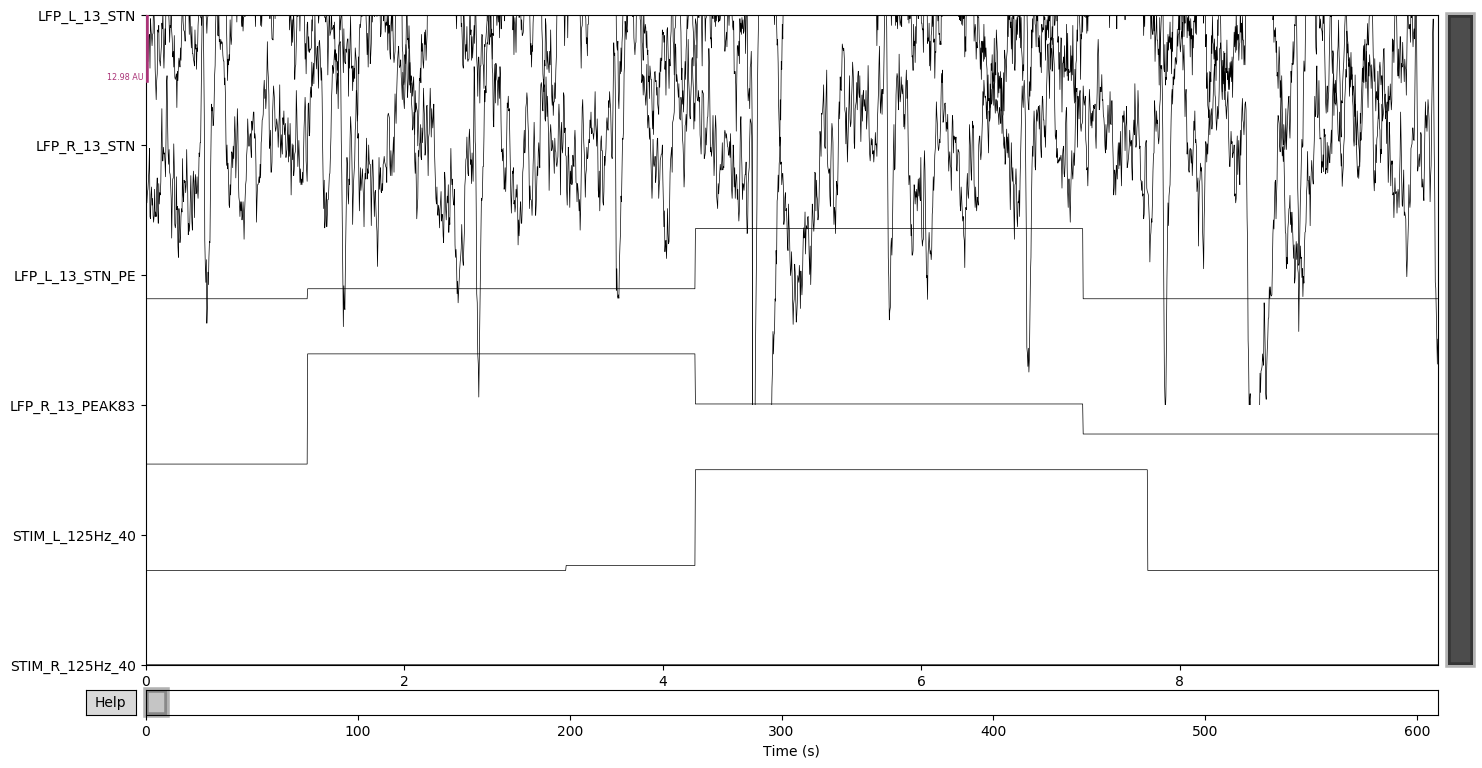

In [42]:
%matplotlib qt 
raw.plot()

In [ ]:
#Interactive plot for artefact rejection
%matplotlib qt 

fig = raw.plot(n_channels = 2, highpass = 5, lowpass = 100, 
    filtorder = 5, duration = 20)

In [7]:
#First time making them
interactive_annot = raw.annotations
raw.annotations.save('Sub017_RampUpThres_artefactsAnnotations.csv', 
    overwrite = True)

In [4]:
#Importing them later
interactive_annot = pd.read_csv(
    os.path.join(
        ftg_path,
        'data',
        'raw_data',
        'clean_fifs',
        'sub017',
        'Sub017_RampUpThres_artefactsAnnotations.csv'
    )
)

#fix timing in imported annotations
reload(fix_annot_onsets)
new_onsets = fix_annot_onsets.fix_annot_onsets(interactive_annot)
print(new_onsets)

[  5.6  12.2  19.1  21.3  92.   98.1 137.8 237.9 264.5 389.3 415.4 424.6
 450.1 474.3 498.  531.8 572.2 610.5 645.5 711.8 737.1]


In [5]:
my_annot = mne.Annotations(onset=new_onsets,  # in seconds
                           duration=interactive_annot.duration,  # in seconds, too
                           description=interactive_annot.description,
                           orig_time=raw.info['meas_date'])

reload(mat2fif)
%matplotlib qt
new_raw = mat2fif.mat2fif(raw,my_annot)

Omitting 9777 of 188625 (5.18%) samples, retaining 178848 (94.82%) samples.
Creating RawArray with float64 data, n_channels=6, n_times=178848
    Range : 0 ... 178847 =      0.000 ...   715.388 secs
Ready.


In [ ]:
import matplotlib.patches as patches
%matplotlib qt
fig, axs = plt.subplots(2, figsize=(15, 15))

fig.suptitle('sub-029_ses-EphysMedOn01_task-RampUpThres125_acq-StimOnR2b_run-01')

ax2 = axs[1].twinx()
axs[0].plot(new_raw.times, new_raw.get_data(picks = 'Accel_Z')[0])

axs[1].specgram(x = new_raw.get_data(picks = 1)[0], Fs = 250, noverlap = 0.5, cmap = 'viridis',
                        vmin = -25, vmax = 10)
axs[1].set_ylim(bottom = 5,top = 100)
ax2.plot(new_raw.times, new_raw.get_data(picks = 'STIM_R_125Hz_60')[0]/3, 'w', linewidth = 1.5)
ax2.set_yticks(np.arange(0,4.5,1))
axs[1].set_yticks(np.arange(0,120,20))
ax2.set_ylabel('Stimulation Amplitude [mA]')
axs[1].set_ylabel('Frequency [Hz]')
axs[1].set_xlabel('Time [sec]')
axs[0].set_ylabel('Acceleration [m/S^2]')

'''
rect1 = patches.Rectangle((220,1),20,100,facecolor = 'red', alpha = 0.2)
rect2 = patches.Rectangle((362,1),13,100,facecolor = 'red', alpha = 0.2)

rect3 = patches.Rectangle((241,1),12,100,facecolor = 'black', alpha = 0.3)
rect4 = patches.Rectangle((264,1),10,100,facecolor = 'black', alpha = 0.3)
rect5 = patches.Rectangle((285,1),15,100,facecolor = 'black', alpha = 0.3)
rect6 = patches.Rectangle((379,1),10,100,facecolor = 'black', alpha = 0.3)
rect7 = patches.Rectangle((399,1),12,100,facecolor = 'black', alpha = 0.3)
rect8 = patches.Rectangle((421,1),11,100,facecolor = 'black', alpha = 0.3)

axs[1].add_patch(rect1)
axs[1].add_patch(rect2)
axs[1].add_patch(rect3)
axs[1].add_patch(rect4)
axs[1].add_patch(rect5)
axs[1].add_patch(rect6)
axs[1].add_patch(rect7)
axs[1].add_patch(rect8)
'''
matplotlib.rc('font', size=20)
#plt.plot(new_raw.times, new_raw.get_data(picks = 'STIM_R_125Hz_60')[0])

In [5]:
#Plot TF plot with artefact rejected data
%matplotlib qt
matplotlib.rc('font', size=10)
reload(dat_preproc)
x = raw.get_data(reject_by_annotation = 'omit',picks=[0,1])
raw = raw
win_samp = 250
noverlap = 0.5
window = hann(win_samp, sym=False)
f, t, Sxx = dat_preproc.fft_rawviz(raw, x, win_samp, noverlap)

### Create Combined Figure with Dyskinesia Rates & Recording

In [ ]:
%matplotlib qt
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [1, 3]})

#fig.suptitle('sub-029_ses-EphysMedOn01_task-Bilateral_acq-StimOnR2b_run-01')

axs[0].plot()

ax2 = axs[1].twinx()
axs[1].specgram(x = raw.get_data(picks = 1)[0], Fs = 250, noverlap = 0.5, cmap = 'viridis',
                        vmin = -25, vmax = 10)
axs[1].set_ylim(bottom = 5,top = 100)
ax2.plot(raw.times, raw.get_data(picks = 'STIM_R_145Hz_60')[0]/3, 'w', linewidth = 1.5, label = 'Stim RSTN')
ax2.plot(raw.times, raw.get_data(picks = 'STIM_L_145Hz_60')[0], 'w', linestyle='dashed',alpha = 0.8, linewidth = 1.5, label = 'Stim LSTN')
axs[1].set_xlim(413, 720)
ax2.set_yticks(np.arange(0,4.5,1))
axs[1].set_yticks(np.arange(0,120,20))
ax2.set_ylabel('Stimulation Amplitude [mA]')
axs[1].set_ylabel('Frequency [Hz]')
axs[1].set_xlabel('Time [sec]')
#plt.legend(loc = 2)

### Plot Power Spectra in Epochs

In [ ]:
%matplotlib inline
stim_onsets = [1, 30, 110, 240]
labels = ['Ipsi_Stim','NoStim','Contra_Stim','Bilateral']
dur = 20

#for l in range(0,4):
    #plt.plot(np.mean(Sxx[1,:,stim_onsets[l]:stim_onsets[l]+dur],1), label = labels[l])
    #plt.xlim(40, 90)
    #plt.ylim(0,0.5)
tt, Pxx = scipy.signal.welch(Sxx[1,1:20], fs = 250, nperseg = 250, noverlap = 0.25)
plt.plot(np.arange(1,127), np.mean(Pxx[0],1), label = labels[l])

plt.legend(labels)

### Analytic Signal Trial

In [30]:
232*250

58000

In [6]:
reload(dat_preproc)
x = raw.get_data(reject_by_annotation = 'omit') #getting only RSTN channel

x1 = x[0, 58000:-1] 

dat_subh = dat_preproc.low_highpass_filter(x1, 61, 65) #filtering for 60-65Hz
dat_ngam = dat_preproc.low_highpass_filter(x1, 79, 83) #filtering for 80-90Hz
dat_bet = dat_preproc.low_highpass_filter(x1, 30, 35) #filtering for 23-35Hz

datall = [dat_bet, dat_subh, dat_ngam] 
labels = ['High Beta','Subharmonic [60-65Hz]','FTG [82-87Hz]']

In [49]:
x1.shape

(118343,)

In [7]:
def window_rms(a, window_size):
  a2 = np.power(a,2)
  window = np.ones(window_size)/float(window_size)
  return np.sqrt(np.convolve(a2, window, 'valid'))

In [9]:
sm_signal.shape

(93188,)

In [21]:
1250/250

5.0

In [10]:
sm_signal_np = np.empty(shape = (3, 93188))
sm_signal_np[:] = np.nan

fig, axes = plt.subplots(3, 1, figsize=(12, 5))
wintosmooth = 1250

for idx, dat in enumerate(datall):
    hiltr = hilbert(dat)
    amplitude_envelope = np.abs(hiltr)
    zscore_sign = stats.zscore(amplitude_envelope)

    sm_signal = window_rms(zscore_sign, wintosmooth)
    
    axes[idx].plot(sm_signal)
    #plt.plot(np.arange(0,75000), amplitude_envelope, label = labels[idx]) 
    
    #axes[idx].axvline(26250, color = 'b', ls='--', lw=2, label = 'Stim On')
    #axes[idx].axvline(50250, color = 'g', ls='--', lw=2, label = 'Stim Off')
    axes[idx].set_ylabel(str(labels[idx])+ ' Env.')
    axes[idx].set_xlim([0, sm_signal.shape[0]])

    if idx == 1 or idx == 2:
        axes[idx].set_ylim(0,2)
    
    sm_signal_np[idx,:] = sm_signal

    #axes[idx].set_xticks(ticks = np.arange(0, 80000, 10000), labels = np.arange(0,320,40))
    plt.xlabel('Time [sec]')

    

plt.suptitle('Smoothing Window: 125 samples')
axes[0].legend(loc='upper right')

plt.show()

No handles with labels found to put in legend.


In [11]:
x2 = x[4, 58000:-1] 
sm_stim = window_rms(x2, wintosmooth)
sm_stim1 = (sm_stim + 1)/3

In [12]:
newlabs = ['High Beta [30-35]','Subharmonic [61-65Hz]','FTG [82-87Hz]']
fig, ax1 = plt.subplots()
plt.rcParams['font.size'] = 18
ax2 = ax1.twinx()
for idx, dat in enumerate(sm_signal_np):
    ax1.plot(sm_signal_np[idx,:], label = newlabs[idx], lw = 2)
ax2.plot(sm_stim1, label = 'Stimulation', color = 'grey', ls='--', lw=3, alpha = 0.4)
ax1.legend()
ax1.set_ylabel('Z-scored Smoothed Analytic Signal')
ax2.set_ylabel('Stimulation Amplitude [mA]')
ax2.set_yticks(np.arange(0.5, 2.5, 0.25))
ax2.set_yticklabels(np.arange(0.25, 2.25, 0.25))
#ax1.set_xlim(0, sm_signal_np.shape[0])
ax1.set_xticks(np.arange(0, 70000, 10000))
ax1.set_xticklabels(np.arange(0, 280, 40))
ax1.set_xlabel('Time [sec]')

plt.show()

In [ ]:
# let's explore some frequency bands
iter_freqs = [
    ('Beta', 13, 35),
    ('SubGamma', 60, 65),
    ('NarrGamma', 65, 90)
]